# Convolutional Neural Networks

Were going to start with the same data we used in the previous notebook to start 
diving into Convolutional Neural Networks

In [1]:
import os
import os.path
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import random
from sys import version
from wshelpers import plot_history
print("Import complete")   

Import complete


A Single Image:
 [[  0   0   0   0   0   1   0   0   0   0  41 188 103  54  48  43  87 168 133  16   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  49 136 219 216 228 236 255 255 255 255 217 215 254 231 160  45   0   0   0   0   0]
 [  0   0   0   0   0  14 176 222 224 212 203 198 196 200 215 204 202 201 201 201 209 218 224 164   0   0   0   0]
 [  0   0   0   0   0 188 219 200 198 202 198 199 199 201 196 198 198 200 200 200 200 201 200 225  41   0   0   0]
 [  0   0   0   0  51 219 199 203 203 212 238 248 250 245 249 246 247 252 248 235 207 203 203 222 140   0   0   0]
 [  0   0   0   0 116 226 206 204 207 204 101  75  47  73  48  50  45  51  63 113 222 202 206 220 224   0   0   0]
 [  0   0   0   0 200 222 209 203 215 200   0  70  98   0 103  59  68  71  49   0 219 206 214 210 250  38   0   0]
 [  0   0   0   0 247 218 212 210 215 214   0 254 243 139 255 174 251 255 205   0 215 217 214 208 220  95   0   0]
 [  0   0   0  45 226 214 214 215 224 205   0  42  35  60  16  

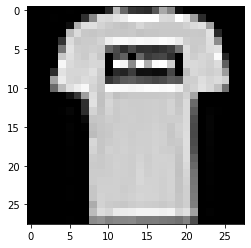

Example Label: 0


In [2]:
# Load pre-shuffled MNIST data into train and test sets
(_xtrain, _ytrain), (X_test, Y_test) = tf.keras.datasets.fashion_mnist.load_data()

#We want to include a develop set so let's split the training set
train_index=[]
develop_index=[]
for i in range(len(_xtrain)):
    if random() <0.8:
        train_index.append(i)
    else:
        develop_index.append(i)
X_train=_xtrain[train_index]
Y_train=_ytrain[train_index]

X_develop=_xtrain[develop_index]
Y_develop=_ytrain[develop_index]


np.set_printoptions(linewidth=115)
n_targets=np.max(Y_test)+1
print('A Single Image:\n',X_train[0])
plt.imshow(X_train[0],cmap='gray')
plt.show()
print('Example Label:', Y_train[0])

* Note above that the labels are integers from 0-9
* Also note the images are integers from 0-255 (uint8)

We will deal with the labels first. Lets make some useful arrays and dictionaries to keep track of what each integer means 

In [3]:
# This is useful for making plots it takes an integer
lookup_dict={
    0 :'T-shirt/top',
    1 :'Trouser',
    2 :'Pullover',
    3 :'Dress',
    4 :'Coat',
    5 :'Sandal',
    6 :'Shirt',
    7 :'Sneaker',
    8 :'Bag',
    9 :'Ankle boot' 
}


#Lets make a list in the order of the labels above so [T-Shirt,Trouser,...]
labels=list(lookup_dict.values())

#Check to make sure labels list is in the right order (not guaranteed in python < 3.6)
if not all([v==lookup_dict[i] for i,v in enumerate(labels) ]):
    print('This looks like an old version of python making labels the long way, you are using python version', version)
    labels=['' for i in range(n_targets) ] #make a list with the right size
    for key in lookup_dict:
        labels[key]=lookup_dict[key] #Assign list to the vaules
        
#Always good to make simple checks that what you think is going to work actually is working
#Here we check that our array of labels is in the same order as the dictionary we wrote above
assert(all([v==lookup_dict[i] for i,v in enumerate(labels) ]))
print("Array and dictionary are in same order")    

#Another Simple Check (Keras is well tested this will work, but it's good to get in the habit when using your own data)
assert(len(X_train)==len(Y_train))
print("X_train and Y_train are the same length") 
assert(len(X_develop)==len(Y_develop))
print("X_develop and Y_develop are the same length")   
assert(len(X_test)==len(Y_test))
print("X_test and Y_test are the same length")  

Array and dictionary are in same order
X_train and Y_train are the same length
X_develop and Y_develop are the same length
X_test and Y_test are the same length


In [4]:
Y_train_one_hot = tf.keras.utils.to_categorical(Y_train, 10)
Y_develop_one_hot =  tf.keras.utils.to_categorical(Y_develop, 10)
Y_test_one_hot =  tf.keras.utils.to_categorical(Y_test, 10)

print('Example:',Y_train[0],'=',Y_train_one_hot[0])

Example: 0 = [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Now lets handle the image data
* Our Convolutional Neural Networks need a shape of Batch x Height x Width x Channels, for us (batch_size x 28 x 28 x 1)
* In this case channels=1, but for a color image you'll have 3 RGB and sometimes 4 with a transparency channel RGBA 
* It's much easier for a neural network to handle data with range from 0-1, rather than 0-255, so we will scale the data

Datatype: uint8 
Max value: 255


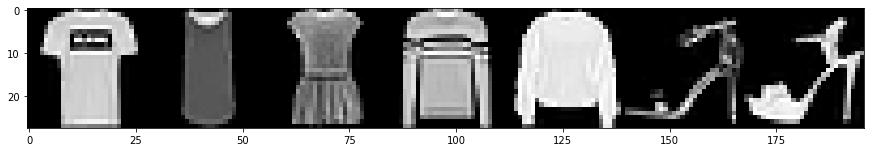

In [5]:

f=plt.figure(figsize=(15,3))
plt.imshow(np.squeeze(np.hstack(X_train[0:7])),cmap='gray') #hstack aranges the first 7 images into one long image

#Reshape
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_develop = X_develop.reshape(X_develop.shape[0], 28, 28, 1)


print("Datatype:",X_train.dtype, "\nMax value:", X_train.max())

Notice that the pixel values imported as an integer array that saturates at `255`.  Let's turn the data into floats $\in [0, 1]$.

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

if X_train.max()>1:  
    X_train = X_train/255
    X_test = X_test/255
    X_develop = X_develop/255

assert(np.max(X_train) <=1)
assert(np.max(X_test) <=1)
assert(np.max(X_develop) <=1)
print("all sets scaled to float values between", X_train.min(), "and", X_train.max())


all sets scaled to float values between 0.0 and 1.0


# Convolutional Neural Networks


The above networks may or may not have worked particularly well, and while it's possible to get a network like this give you good accuracy all the time it requires some work, tunning, and has a bigger issue. Look at the summary of our first neural network





```
Layer (type)           Output Shape              Param #  
=================================================================
flatten (Flatten)      (None, 784)               0       
_________________________________________________________________

dense(Dense)           (None, 100)              78500      
_________________________________________________________________
 ```


our first layer has 28 * 28 * 1 * 100 = 78,500 weights, which is fine for this size image.  What about using even a low resolution image of 300 * 300 * 3 * 100= 27 Million parameters for one layer. This is still possible with modern GPUs, but does not general yield good results. We need a solution that does not scale with with the number of pixels!



A 300x300x3 pixel Image
<img src="../assets/small_img.jpg" style="width:100">

Neural Networks also don't fully utilize what we know about images for example we know that a rock above would still be a rock if we've moved it several pixels to the right of left, but a Dense network would have to learn a whole new set of weights to find a rock a every location in an image. This isn't very efficient. 

* Dense Neural networks treat each pixel as a separate features
    * In image analysis we are often looking for a group of pixels somewhere in an image
        *i.e. Cells, Tumors, or Ankle boots
* We can use a new Layer that looks at a small patch of the image to create an interesting feature
    * This is a **Convolutional Neural Network**


<img src="http://cs231n.github.io/assets/cnn/cnn.jpeg" style="width:100">


CNNs preserve the spatial (2-D) information of the input images, add a depth to their layers, and reduce the number of connections (and therefore weights).

The layers used to build CNN *architectures* fall into three categories:
 1. Convolutional Layer
 1. Pooling Layer
 1. Fully-Connected Layer

## Convolutional layer

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" style="width=100">

Convolutional layers consist of a set of filters that apply over a small spatial area, but the full depth of the input.  The example above shows on the left a [32x32x3] input volume (width 32, height 32 image with RGB color channels).  The volume on the right is an example of a convolutional layer, with a particular **depth column** highlighted which takes as input *only* the highlighted region of the input volume.  The spatial extent of the area covered by a depth column is referred to as the **receptive field**.

The dimensions of the *output volume* are decided by 3 hyperparameters: **depth**, **stride**, and **zero-padding**.  We can compute the size of the output volume based on the volume size $W$, the receptive field size of the convolution layer $F$, their applied stride $S$, and the amount of zero padding used $P$.

Based on these parameters, the number of pixels in the output of a convolutional layer is $(W−F+2P)/S+1$. 

# 1D Example
<img src="http://cs231n.github.io/assets/cnn/stride.jpeg">





### Parameter sharing

Below is a 1-D example with inputs on the bottom in blue ($W=5$) with a padding of 1 ($P=1$), and two different examples of a convolutional filter in red, both with receptive field $F=3$.

*Left*: This is a convolutional layer with stride $S = 2$, meaning we expect ($5 - 3 + 2)/2+1 = 5$ neurons (i.e., outputs).

*Right*: Layer with stride $S = 2$, meaning an output of size $(5 - 3 + 2)/2+1 = 3$.

Note how on the left the zero padding allowed us to have the same number of outputs as inputs.  This is a common use of zero-padding.

We can dramatically reduce the number of parameters involved in a convolutional layer by making the assumption that if one feature is useful to compute at some spatial position (x,y), then it should also be useful to compute at a different position (x2,y2).

In other words, denoting a single 2-dimensional slice of depth as a depth slice (e.g. a volume of size [7x7x3] has 3 depth slices, each of size [7x7]), we are going to constrain the pixels in each depth slice to use the same weights and bias. All $7\times7$ pixels in each depth slice will now be using the same parameters.



# 2D Example
<img src="../assets/2D_CNN.jpg" style="width:100">

# How a CNN Filter Scans


<img src="https://harishnarayanan.org/images/writing/artistic-style-transfer/conv-layer.gif">



Lets look at the how the first output pixel is calculated

|X[0:3,0:3,0]|W0[:,:,0]| 
|------ | ------|
|0,0,0  |-1,0,1|
|0,0,0  |0,0,1 |
|0,1,0  |1,-1,1|
|first channel = | -1|
+
|X[0:3,0:3,1]|W0[:,:,1]|
|0,0,0  |-1,0,1|
|0,2,1  |1,-1,1|
|0,2,1  |0,1,0|
|second channel = |1|
+
|X[0:3,0:3,2]|W0[:,:,2]|
|0,0,0  |-1,1,1|
|0,2,1  |1,1,0 |
|0,1,0  |0,-1,0|
|third channel= | 1|
|bias = |1 |
|Sum Total| 2 = O[0,0,0]|



## Pooling

Pooling layers act to reduce the dimension of the propagated volume, reducing the number of weights going forward, reducing cost and reducing the chances of over-fitting.  It operates independently on each depth slice.  A common operation is to take the MAX over a region.

<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" style="width:300">

For example,
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" style="width:500">

**NOTE**: These are being used less and less these days, in favor of other methods such as strided convolutions seen above.



Let's return to the MNIST hand-written digits data set.  First we'll download some external images that will be useful for visualizations later.

## An Example Model

In keras we can do everything we discussed above by adding an extra layer


* tf.keras.layers.Convolution2D(Number of Filters, (Filter Size)

## Our example model
* One convolutional layer
    * 10 Filters
    * Each filter (28x28)
* Maxpooling
* Softmax layer

Each filter is the size of our entire image, and goes directly into predictions

**Note**: This is not a standard algorithm design, but does show
* How a filter works
* How we can view intermediate layers
* Will build some intuition when using CNNs



In [7]:
cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not including the batch size 
cnn_layer1=tf.keras.layers.Convolution2D(10, (28,28),padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 
max_pooling=tf.keras.layers.MaxPooling2D(28)(cnn_activation) 
flat=tf.keras.layers.Flatten()(max_pooling) 
output=tf.keras.layers.Activation('softmax')(flat)
model=tf.keras.models.Model([cnn_input],[output])
model.summary()


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history=model.fit(X_train, Y_train_one_hot, 
          batch_size=32, epochs=5, verbose=1,
         validation_data=(X_develop,Y_develop_one_hot)
         )

2022-02-11 16:02:10.839035: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-11 16:02:14.324242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38428 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 10)        7850      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 10)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 10)          0         
_________________________________________________________________
flatten (Flatten)            (None, 10)                0         
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
___________________________________________________________

2022-02-11 16:02:16.606628: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-02-11 16:02:20.470131: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2022-02-11 16:02:26.226433: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Running ptxas --version returned 32512
2022-02-11 16:02:26.276829: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 32512, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1499/1499 [==============================] - 20s 2ms/step - loss: 0.7531 - accuracy: 0.7576 - val_loss: 0.5675 - val_accuracy: 0.8074
Epoch 2/5
1499/1499 [==============================] - 3s 2ms/step - loss: 0.5236 - accuracy: 0.8156 - val_loss: 0.5129 - val_accuracy: 0.8158
Epoch 3/5
1499/1499 [==============================] - 2s 2ms/step - loss: 0.4789 - accuracy: 0.8302 - val_loss: 0.4784 - val_accuracy: 0.8276
Epoch 4/5
1499/1499 [==============================] - 2s 2ms/step - loss: 0.4537 - accuracy: 0.8370 - val_loss: 0.4668 - val_accuracy: 0.8318
Epoch 5/5
1499/1499 [==============================] - 2s 2ms/step - loss: 0.4365 - accuracy: 0.8432 - val_loss: 0.4507 - val_accuracy: 0.8366


## Looking under the hood

* We can use something called a keras function to explore our model layer by layer
* A keras function is a lot like a keras Model, but doesn't have any code to do things like fitting

tf.keras.backend.function([...Inputs...],[...outputs...])

Input


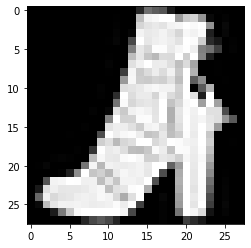

CNN layer filters
(28, 28, 10)


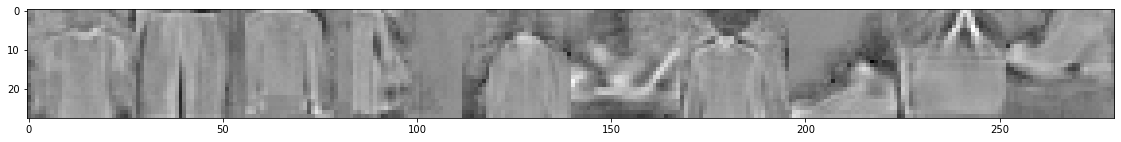

CNN Layer Output
(1, 28, 28, 10)


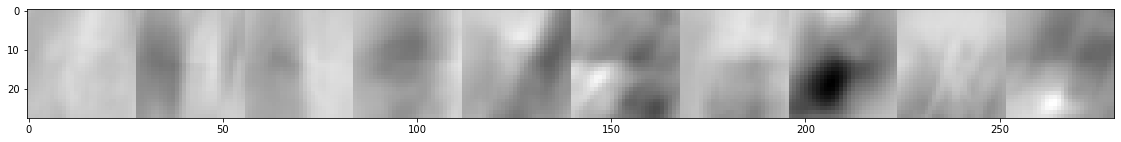

Activation


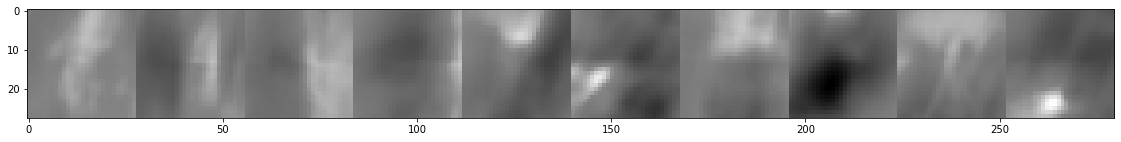

Pooling
[11.73914  11.214137 10.170202 12.482964 16.35927  20.260504 13.143088  8.663911  9.687573 24.441584]
Softmax
[2.9968792e-06 1.7728155e-06 6.2414915e-07 6.3053308e-06 3.0420505e-04 1.5047027e-02 1.2201029e-05 1.3839308e-07
 3.8519923e-07 9.8462439e-01]
Guess 9
Actual 9


In [8]:
#A function to get the output of all layers (except the first which is the input layer)
image_index=8


layers=tf.keras.backend.function([model.input],[ l.output for l in model.layers[1:]])


layers_output=layers([X_train[image_index:image_index+1]]) 
 
print("Input")
plt.imshow(np.squeeze(X_train[image_index]),cmap='gray')
plt.show()

print("CNN layer filters")

filters=np.squeeze(model.layers[1].get_weights()[0])
print(filters.shape)
filter_stack=np.hstack([filters[:,:,i] for i in range(10)   ])
f=plt.figure(figsize=(20,2))

plt.imshow(filter_stack,cmap='gray')
plt.show()

print("CNN Layer Output")


print(layers_output[0].shape)
cnn_out=np.squeeze(layers_output[0])

cnn_stack=np.hstack([cnn_out[:,:,i] for i in range(10)   ])
f=plt.figure(figsize=(20,2))
plt.imshow(cnn_stack,cmap='gray')
plt.show()    


print("Activation")
act_out=np.squeeze(layers_output[1])

act_stack=np.hstack([act_out[:,:,i] for i in range(10)   ])
f=plt.figure(figsize=(20,2))
plt.imshow(act_stack,cmap='gray')
plt.show()    


print("Pooling")
pool_out=np.squeeze(layers_output[2])
print(pool_out)

#layer 3 is just a Flatten

print("Softmax")
p_out=np.squeeze(layers_output[4])
print(p_out)
print('Guess',np.argmax(p_out))
print('Actual',Y_train[image_index])


## Building a better model

1. The simplest thing to improve the above model is to add a Dense layer at the end
    * The Convolutional layer will learn the features that go into the dense network
    * Try the above model with a Dense layer at the end
    * Can you still make sense of the filter's?
    
**Give the above a try**


2. Use lots of /smaller filters

The above model (without the Dense layer) essentially learned a template for each class, this worked ok, but doesn't work in general or if you have a huge number of classes. Instead of using a few big filters, we can use a number of small filters, and stack them into deep networks.

* This model will use several small filters
* The layers will be stacked
    * Earlier layer's will do simple things like edge detection
    * Later layers will take those edges as features which lets them learn more complex objects
    
3. Replace MaxPooling with Strided Convolutions
    * Let's the model learn the best way to downsize


# A Better Model

In [9]:
cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not including the batch size 

cnn_layer1=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_input) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 

cnn_layer2=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 

cnn_layer3=tf.keras.layers.Convolution2D(64, (4,4),strides=2,padding='same')(cnn_activation) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 

flat=tf.keras.layers.Flatten()(cnn_activation) 

dense_layer=tf.keras.layers.Dense(10)(flat) 
output=tf.keras.layers.Activation('softmax')(dense_layer)

model=tf.keras.models.Model([cnn_input],[output])
model.summary()



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


history=model.fit(X_train, Y_train_one_hot, 
          batch_size=32, epochs=5, verbose=1,
         validation_data=(X_develop,Y_develop_one_hot)
         )


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          65600     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          65600     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 4, 4, 64)          0   

2022-02-11 16:02:47.428063: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1499/1499 [==============================] - 7s 5ms/step - loss: 0.4736 - accuracy: 0.8303 - val_loss: 0.3950 - val_accuracy: 0.8585
Epoch 2/5
1499/1499 [==============================] - 5s 3ms/step - loss: 0.3457 - accuracy: 0.8761 - val_loss: 0.3479 - val_accuracy: 0.8755
Epoch 3/5
1499/1499 [==============================] - 5s 3ms/step - loss: 0.3068 - accuracy: 0.8884 - val_loss: 0.3283 - val_accuracy: 0.8803
Epoch 4/5
1499/1499 [==============================] - 4s 3ms/step - loss: 0.2807 - accuracy: 0.8973 - val_loss: 0.3050 - val_accuracy: 0.8895
Epoch 5/5
1499/1499 [==============================] - 4s 3ms/step - loss: 0.2579 - accuracy: 0.9056 - val_loss: 0.3189 - val_accuracy: 0.8850


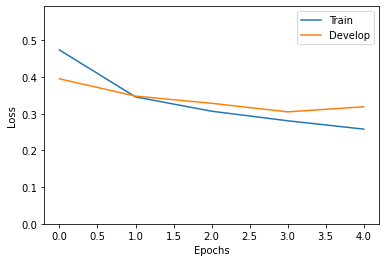

In [10]:
plot_history(history)

## Visualize Intermediate Layers

This network works well, but when we try to visualize the 64 filters, and 64 "activation maps" the output becomes a lot harder to interpret . You may have heard this called the 'black box' problem.

Input


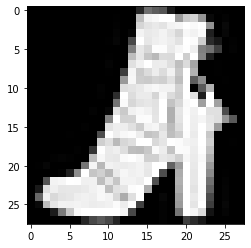

CNN layer filters
(4, 4, 64)


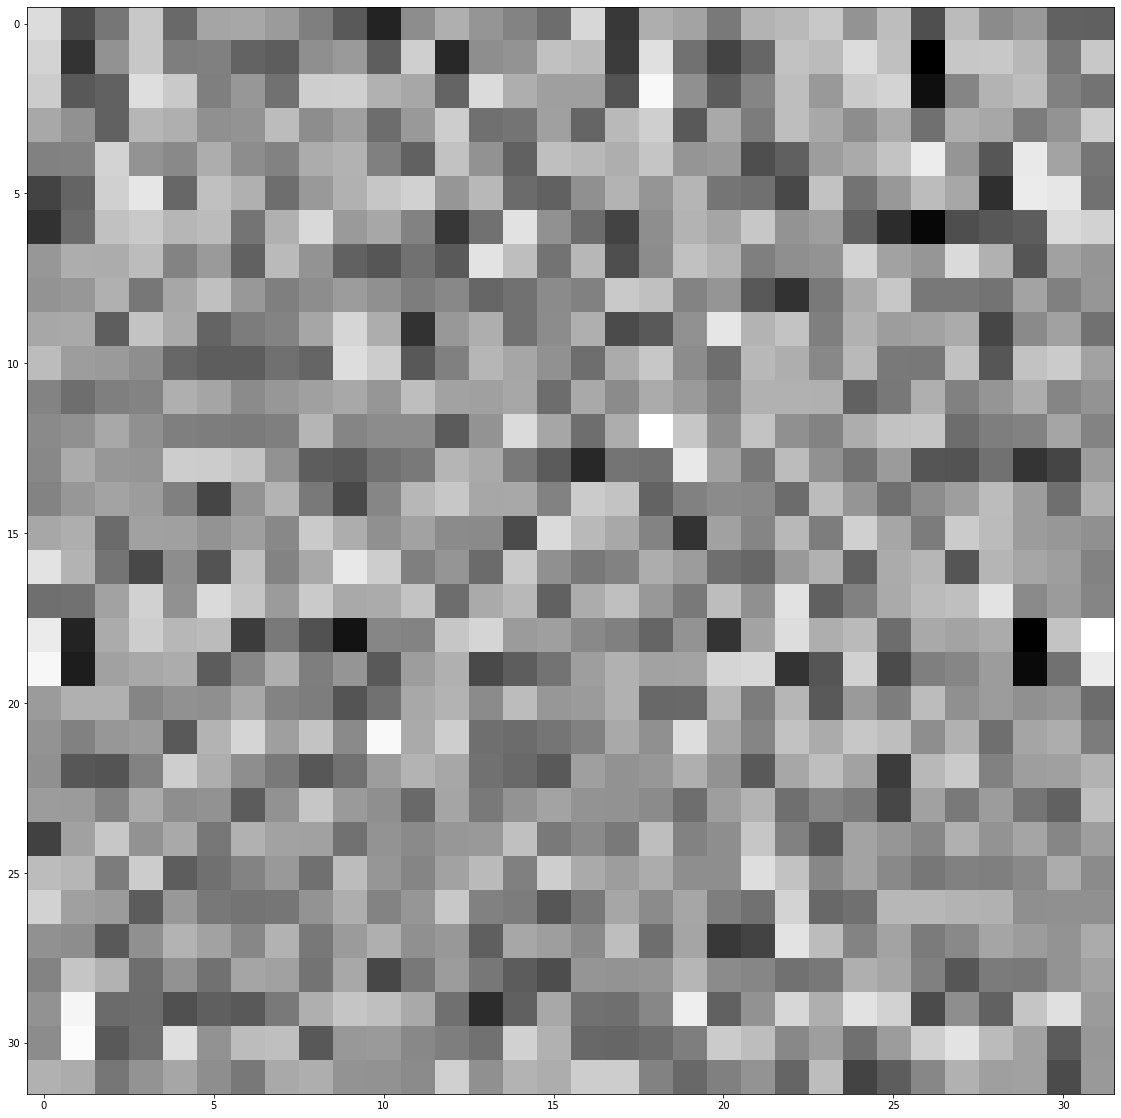

CNN Layer Output
(1, 14, 14, 64)


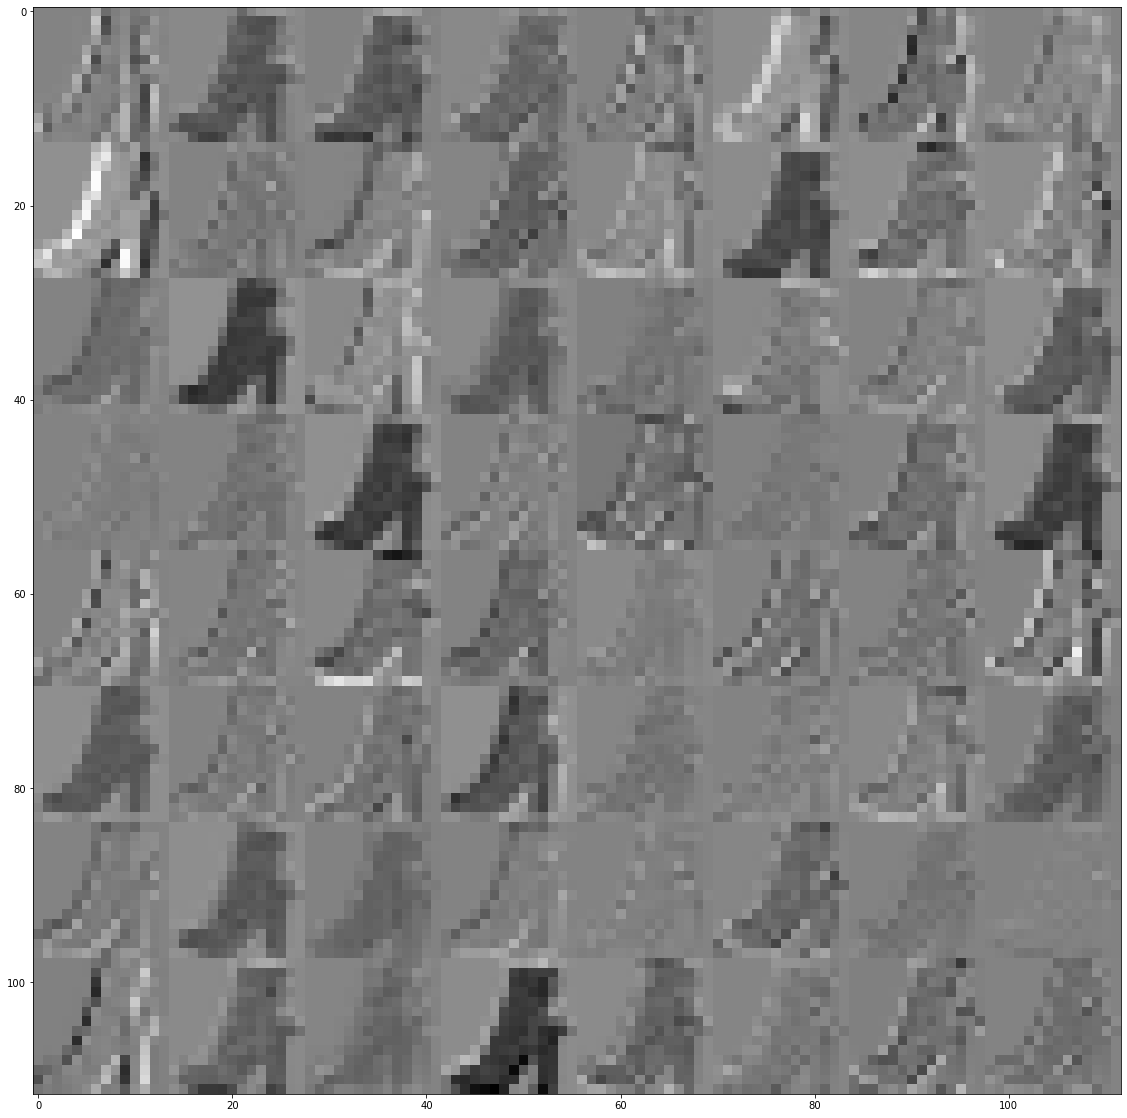

Activation


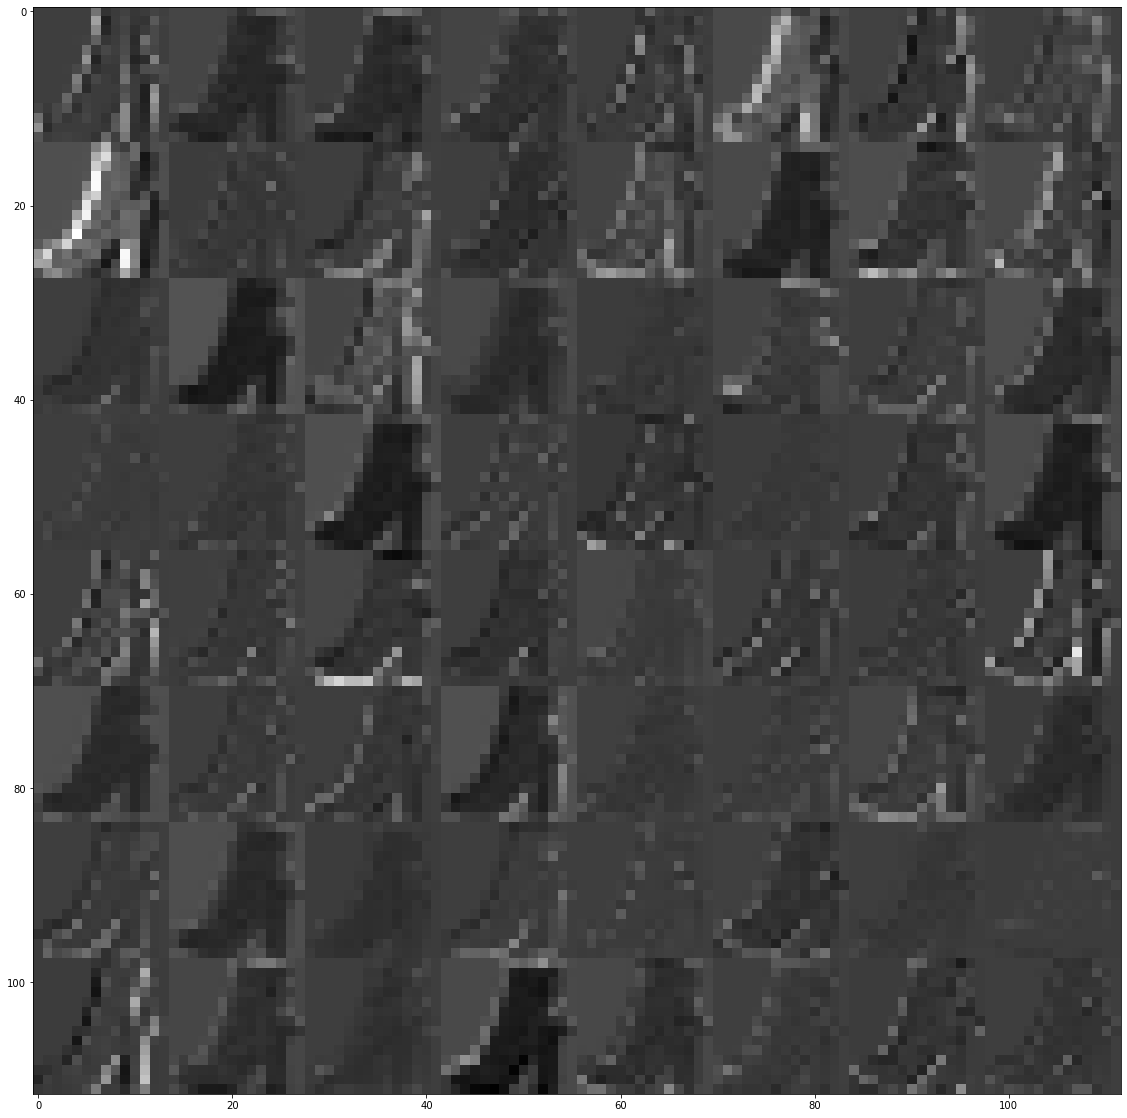

CNN Layer Output
(1, 7, 7, 64)


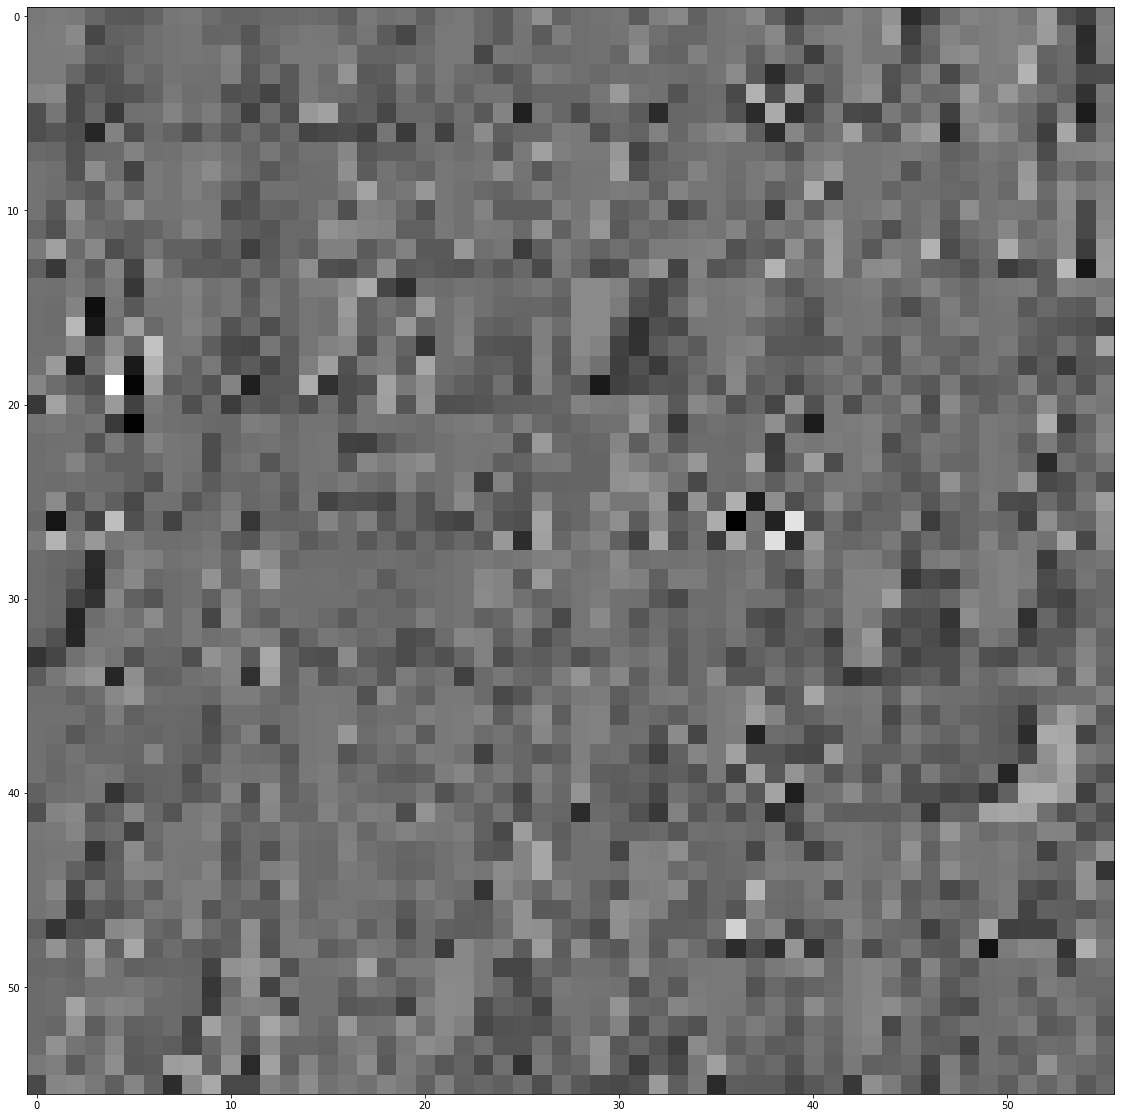

Activation


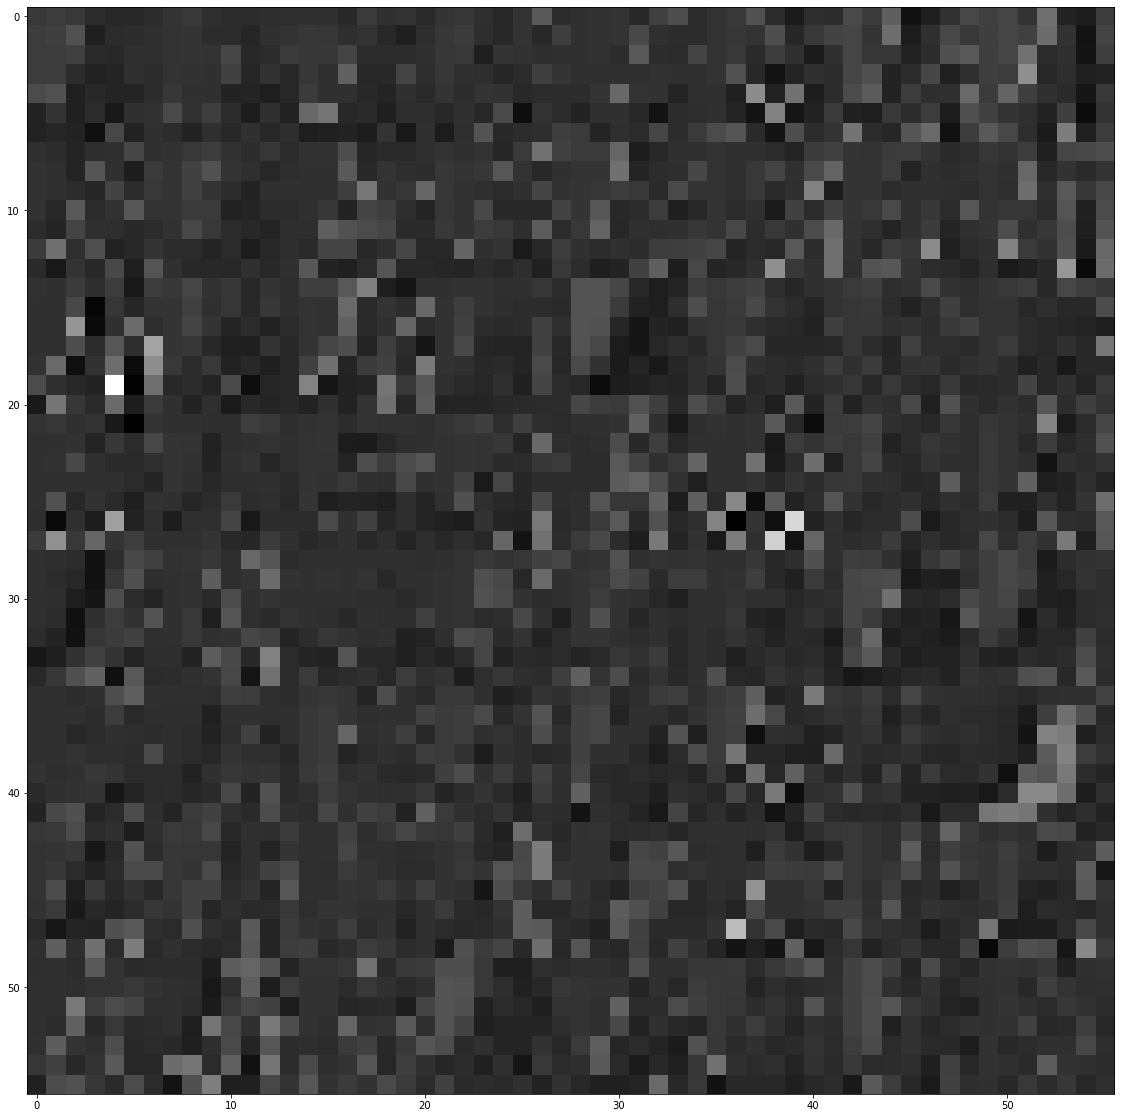

CNN Layer Output
(1, 4, 4, 64)


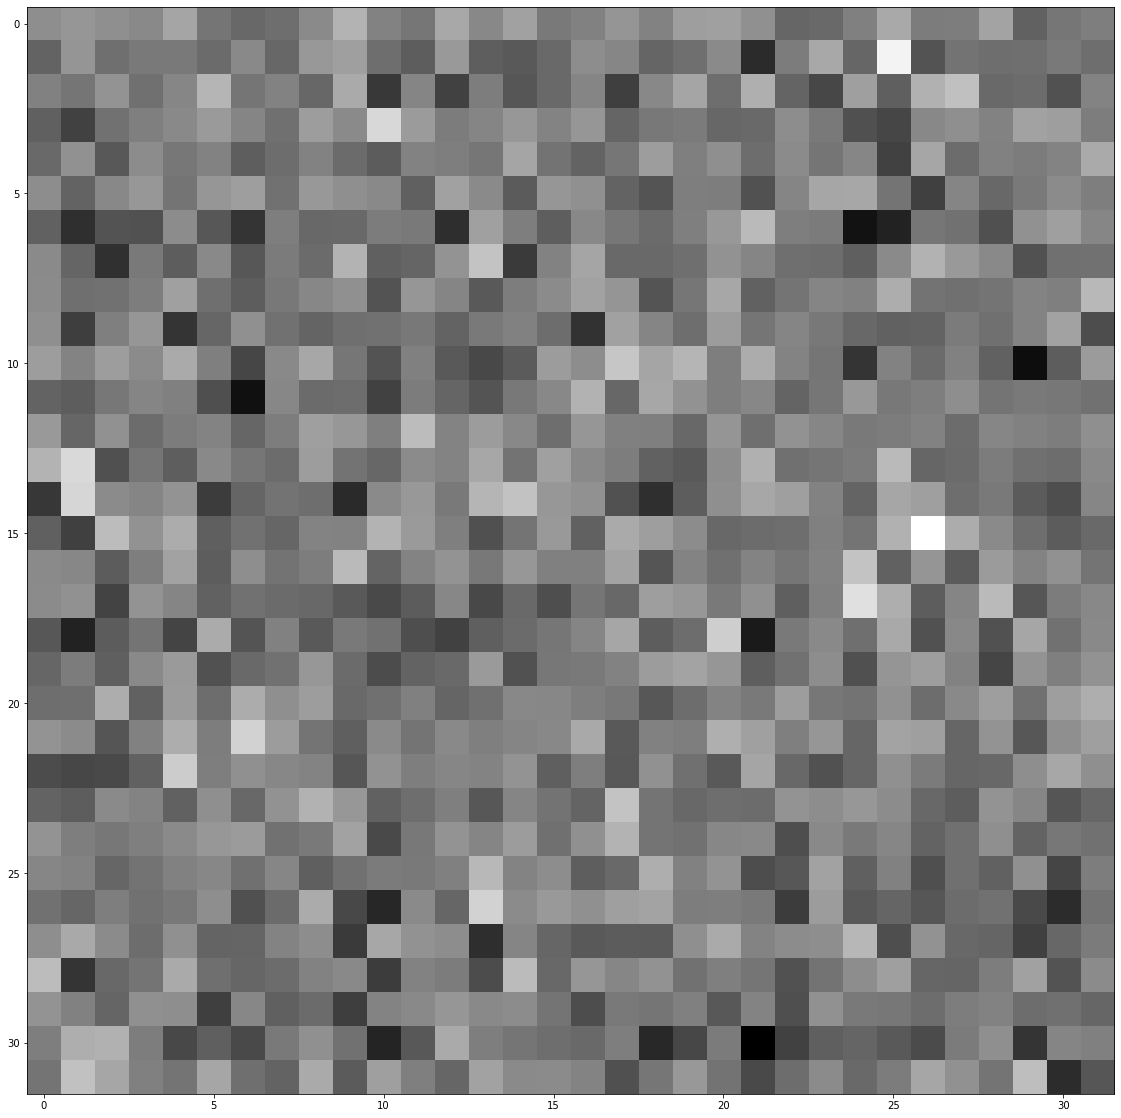

Activation


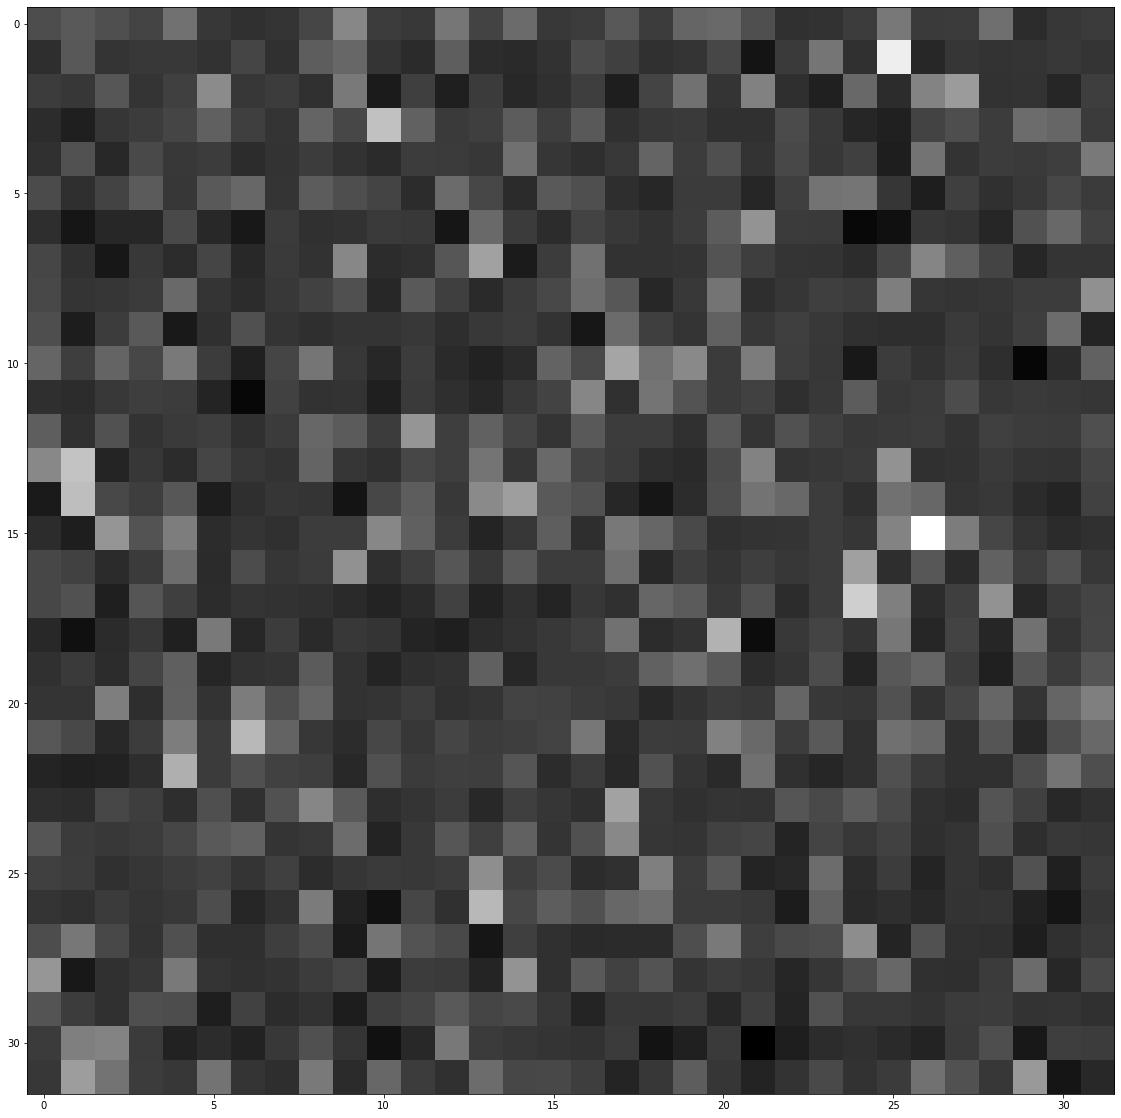

Softmax
[1.0675807e-05 1.0195894e-04 2.5174718e-06 5.0569837e-05 9.3128128e-06 1.5431066e-02 4.6300018e-05 1.5331897e-06
 5.8316934e-04 9.8376286e-01]
Guess 9
Actual 9


In [11]:
#A function to get the output of all layers (except the first which is the input layer)
image_index=8


layers=tf.keras.backend.function([model.input],[ l.output for l in model.layers[1:]])


layers_output=layers([X_train[image_index:image_index+1]]) 
 
print("Input")
plt.imshow(np.squeeze(X_train[image_index]),cmap='gray')
plt.show()


print("CNN layer filters")

filters=np.squeeze(model.layers[1].get_weights()[0])
print(filters.shape)
filter_stack=np.vstack([np.hstack([filters[:,:,i+n*8] for i in range(8)   ]) for n in range(8)])
f=plt.figure(figsize=(20,20))

plt.imshow(filter_stack,cmap='gray')
plt.show()


for layer_index in range(3):

    print("CNN Layer Output")


    print(layers_output[layer_index*2].shape)
    cnn_out=np.squeeze(layers_output[layer_index*2])

    cnn_stack= np.vstack([  np.hstack([cnn_out[:,:,i+8*n] for i in range(8)   ]) for n in range(8)])

    f=plt.figure(figsize=(20,20))
    plt.imshow(cnn_stack,cmap='gray')
    plt.show()    


    print("Activation")
    act_out=np.squeeze(layers_output[1+layer_index*2])

    act_stack= np.vstack([  np.hstack([act_out[:,:,i+8*n] for i in range(8)   ]) for n in range(8)])

   
    f=plt.figure(figsize=(20,20))
    plt.imshow(act_stack,cmap='gray')
    plt.show()    


#    print("Pooling")
#    pool_out=np.squeeze(layers_output[2])
#    print(pool_out)

#layer 3 is just a Flatten

print("Softmax")
p_out=np.squeeze(layers_output[-1])
print(p_out)
print('Guess',np.argmax(p_out))
print('Actual',Y_train[image_index])



# Overfitting

Overfitting generally refers to a trend for ML models to find and exploit statistical fluctuations in your training data that don't accurately reflect the system you are trying to learn. You can think of this a 'memorizing' without any real understanding. A good way of testing whether this is happening or not is to compare the training loss to the loss calculated on a new set of data (with it's own different statistical fluctuations)

* Overfitting is combated 
    * with Dropout (more on that later)
    * with less training or Early stopping (see https://keras.io/callbacks/#earlystopping)

Keras's fit function returns a history object that shows the loss of the training and testing set we can check it for signs of overfitting.

* You expect for the training and testing loss to go down 
* If the model starts overfitting 
    * you'll see the testing loss stop decreasing and even go up 
    * Training loss will continue to go down
* An important detail: Keras has two learning_phases
    * Training: The Model is training and dropout is on reducing available information
    * Testing: This is the setting when using the model for real, dropout is disabled
    * The Training loss is calculated with the training phase (dropout on)
    * The Testing loss is calculated with the testing phase (dropout off)
        * You will often see the Training loss is greater than the testing loss, this is okay if you're using dropout
        * It might not be okay if you're using your own data without dropout
            * Could be a sign the testing data is distributed differently than the training data

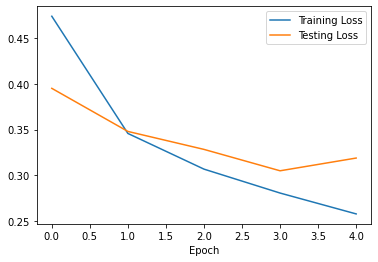

In [12]:
plt.plot(history.history['loss'],label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()

Any sign of overfitting?

# Prediction
Lets look at how the model makes predictions


T-shirt/top 0.0 %
Trouser 0.0 %
Pullover 0.0 %
Dress 0.0 %
Coat 0.0 %
Sandal 0.21 %
Shirt 0.0 %
Sneaker 0.03 %
Bag 0.01 %
Ankle boot 99.75 %
best guess: Ankle boot


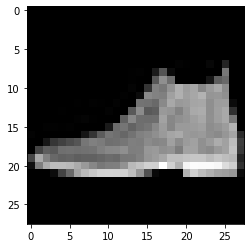

Truth Class: 9 Ankle boot


In [13]:
pred=model.predict(X_test)
for i,p in enumerate(pred[0]):
    print(lookup_dict[i],round(p*100,2),'%')

best_guess=np.argmax(pred[0])
print('best guess:',lookup_dict[best_guess])
plt.imshow(np.squeeze(X_test[0]),cmap='gray')
plt.show()

print('Truth Class:',Y_test[0],lookup_dict[Y_test[0]])


Notice Above that the while the most likely guess is correct (Ankle boot when I ran it 23.2 percent), the model still isn't that confident in it's result. So while the accuracy is good there is still some improvements that might give you better confidences, and lower losses.  

## Other Checks

### Confusion matrix

A confusion matrix is a 2-D histogram with the dimensions being the true class, and the predicted class.
The diagonal bins in this histogram are correct prediction true_class==predicted_class, otherwise it is an
incorrect prediction. Run the cell below and see if you can guess which class is hardest to identify

making 10000 predictions for 10 classes


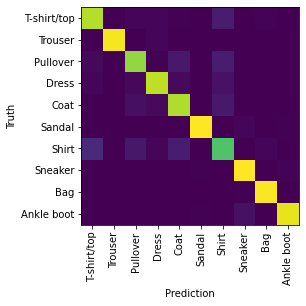

Number of Incorrect Guesses: 970


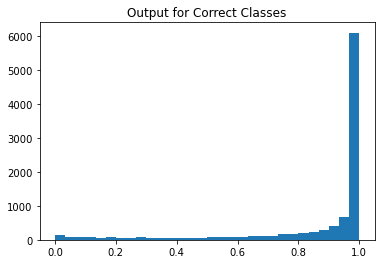

Guess: Sandal /Truth: Ankle boot


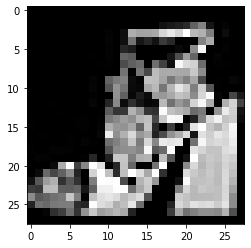

Guess: Bag /Truth: Shirt


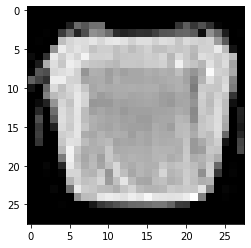

Guess: Dress /Truth: T-shirt/top


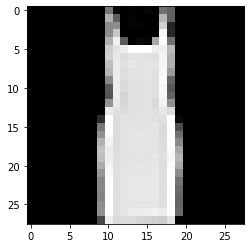

Guess: Pullover /Truth: Bag


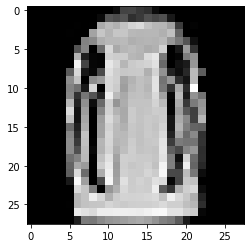

Guess: Bag /Truth: Trouser


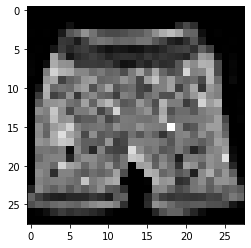

In [30]:
def check(model,x,y,labels=labels):
    pred=model.predict(x)
    print("making", pred.shape[0], "predictions for", pred.shape[1], "classes") 
    best_guess=np.argmax(pred,axis=1)

    confusion_matrix=np.zeros((n_targets,n_targets))
    for truth,guess in zip(y,best_guess):
        confusion_matrix[truth,guess]+=1

    plt.imshow(confusion_matrix)
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.xticks(range(0,10),labels,rotation=90)
    plt.yticks(range(0,10),labels)

    plt.show()
    print('Number of Incorrect Guesses:',np.sum(best_guess!=y))

    
    prediction_for_true_value=[p[i] for p,i in zip(pred,y)  ]

    bins=plt.hist(prediction_for_true_value,bins=30,range=(0,1))
    plt.title('Output for Correct Classes')
    
    worst=np.argsort(prediction_for_true_value)


    plt.show()
    plt.show()

    for index in worst[0:5]:
        print("Guess:", labels[best_guess[index]], "/Truth:",labels[y[index]])
        plt.imshow(np.squeeze(x[index]),cmap='gray')
        plt.show()


check(model,X_test,Y_test)




## Tips and Tricks

* Dropout
* Data Augmentation
* Which Activation functions to use inside your network


In [15]:
#Lets Put of this together into some helpful functions
def build_model(dropout_rate=0.25,nfilters=32,use_leakyRelu=False,activation='relu'):
    if use_leakyRelu:
        activation='linear'
    
    cnn_input=tf.keras.layers.Input( shape=X_train.shape[1:] ) # Shape here does not include the batch size 
    cnn_layer1=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_input) #Notice here calling the layer with cnn_input as an argument connects the input layer to this layer 
    if use_leakyRelu:cnn_layer1=tf.keras.layers.LeakyReLU()(cnn_layer1)
    cnn_layer2=tf.keras.layers.Convolution2D(nfilters, (3, 3), activation=activation)(cnn_layer1)
    if use_leakyRelu:cnn_layer2=tf.keras.layers.LeakyReLU()(cnn_layer2)

    max_pool=tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(cnn_layer2)
    dropout=tf.keras.layers.Dropout(dropout_rate)(max_pool)
    flat=tf.keras.layers.Flatten()(dropout)
    
    dense1=tf.keras.layers.Dense(128, activation=activation)(flat)

    dropout_output=tf.keras.layers.Dropout(dropout_rate)(dense1)
    output_no_a=tf.keras.layers.Dense(10)(dropout_output)
    output=tf.keras.layers.Activation('softmax')(output_no_a)
    model=tf.keras.models.Model([cnn_input],[output])
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model
    
def plot_history(history):
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'], label='Testing Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
    

# Dropout

A great diagram I took from the link below.

<img src="https://cdn-images-1.medium.com/max/1600/1*f8YjtxaYPid1Ilkw0tImaw.png">
<a href=https://medium.com/@ahmdtaha/dropout-as-a-bayesian-approximation-representing-model-uncertainty-in-deep-learning-7a2e49e64a15> Link to Article </a>


Dropout randomly removes X% (where x is a hyperparameter) of the data from the previous layer, which makes memorizing the data much more difficult. This encourages the model to learn meaningful and independent features.

Lets look what happens when we train different models, with only a small fraction training dataset (500 images)


### Dropout 0% (no dropout)
<img src="../assets/dropout_0.png"  >
This model quickly overfits

### Dropout 50%
<img src="../assets/dropout_0_50.png" >
This model does a bit better but over time still overfits


### Dropout 70%
<img src="../assets/dropout_0_70.png"  >
This model overfits even slower


### Dropout 90%
<img src="../assets/dropout_0_90.png" >
This model does not overfit, but takes much longer to train







In [16]:
import numpy as np
print(Y_train.shape)
train_data=np.random.choice(range(0,len(X_train))  ,500 )

(47944,)


In [17]:

#Some code to produce the plots above
if False:
    for rate in [0,0.5,0.7,0.9]:
        new_model=build_model(dropout_rate=rate)
        print('Dropout Rate ',rate)
        history=new_model.fit(X_train, Y_train_one_hot[train_data], 
              batch_size=32, epochs=200, verbose=0,
             validation_data=(X_develop,Y_develop_one_hot) )     
        score = new_model.evaluate(X_develop, Y_develop_one_hot)
        print("Develop loss: {}, Develop accuracy: {}".format(*score))

        score = new_model.evaluate(X_train, Y_train_one_hot[train_data])
        print("Train loss: {}, Train accuracy: {}".format(*score))


        plot_history(history)


# Activations

Activations vary mainly on the output layer of a network
* Binary Classification: Sigmoid
* Multi-Class Classification: SoftMax
* Regression: Linear


However, activations can have a large impact on training. 
* I normally use a LeaklyReLU as my default choice
  * Has non zero derivatives at +/- infinity

See how some of the activation change below


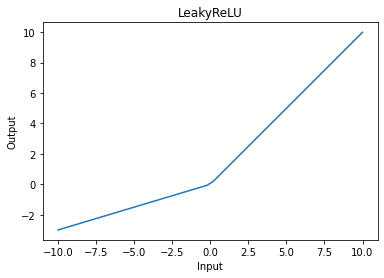

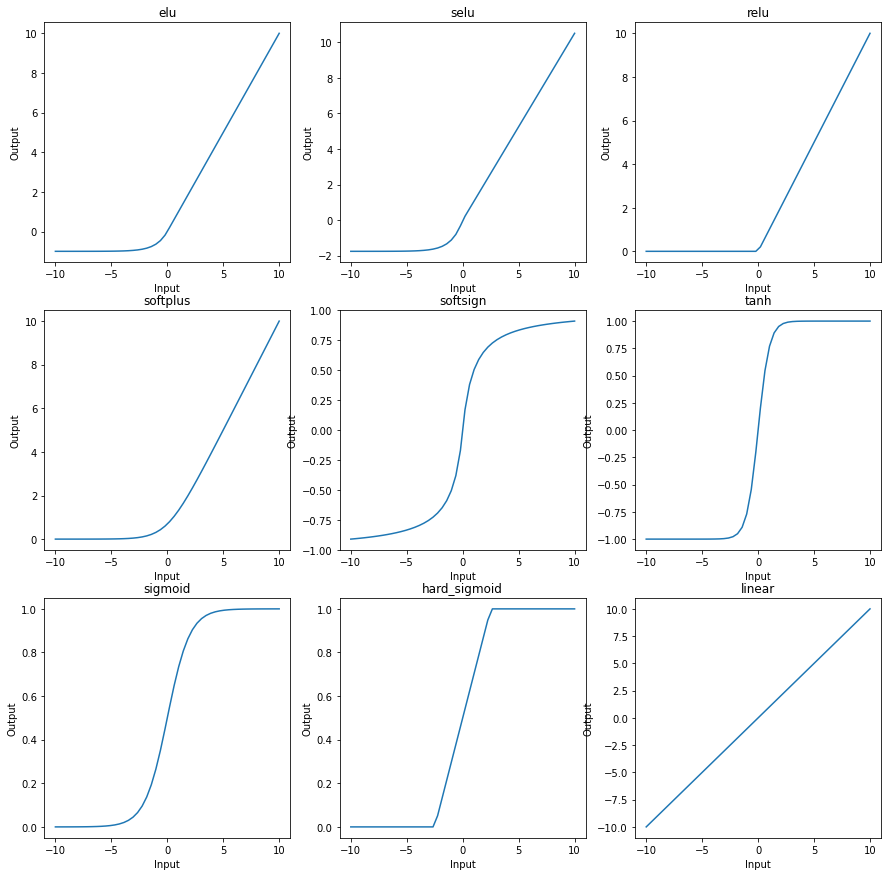

In [18]:
x=np.expand_dims(np.linspace(-10,10,50),1)

act_input=tf.keras.Input((1,)) #Notice the comma after 1, this is a 1 dimentional input to keras
outputl=tf.keras.layers.LeakyReLU()(act_input) #This is an "Advanced Activation, so it has it's own layer"
test_model=tf.keras.models.Model(act_input,outputl)

output=test_model(x)
plt.plot(x,output)
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('LeakyReLU')
plt.show()


plt.figure(figsize=(15,15))    
for i,activation in enumerate(['elu','selu','relu','softplus','softsign','tanh','sigmoid','hard_sigmoid','linear']):
    plt.subplot(3,3,i+1)
    outputl=tf.keras.layers.Activation(activation)(act_input) 
    test_model=tf.keras.models.Model(act_input,outputl)
    output=test_model(x)
    plt.plot(x,output)
    plt.xlabel('Input')
    plt.ylabel('Output')
    plt.title(activation)
plt.show()


## Sigmoid

Epoch 1/10
1499/1499 [==============================] - 4s 3ms/step - loss: 1.0565 - accuracy: 0.6036 - val_loss: 0.5580 - val_accuracy: 0.7858
Epoch 2/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.5774 - accuracy: 0.7831 - val_loss: 0.4758 - val_accuracy: 0.8204
Epoch 3/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.5013 - accuracy: 0.8130 - val_loss: 0.4168 - val_accuracy: 0.8400
Epoch 4/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.4620 - accuracy: 0.8280 - val_loss: 0.3819 - val_accuracy: 0.8580
Epoch 5/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.4294 - accuracy: 0.8426 - val_loss: 0.3663 - val_accuracy: 0.8587
Epoch 6/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.4076 - accuracy: 0.8506 - val_loss: 0.3432 - val_accuracy: 0.8716
Epoch 7/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.3902 - accuracy: 0.8559 - val_loss: 0.3277 - val_accuracy:

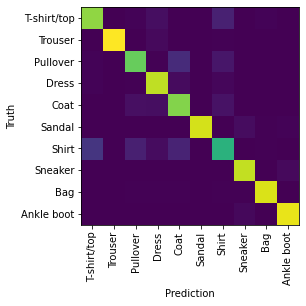

Number of Incorrect Guesses: 1336


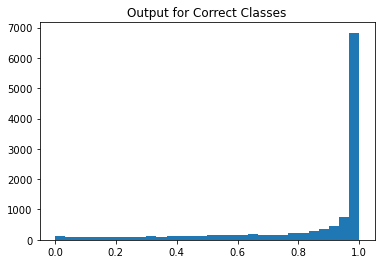

Guess: Dress /Truth: Shirt


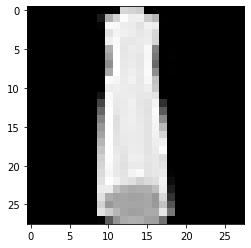

Guess: Dress /Truth: T-shirt/top


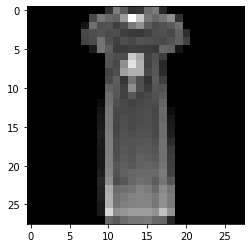

Guess: Dress /Truth: T-shirt/top


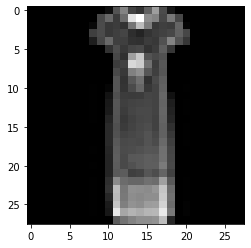

Guess: Bag /Truth: Trouser


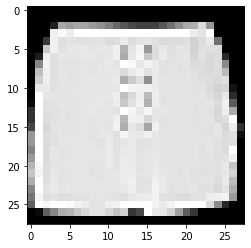

Guess: Sneaker /Truth: Bag


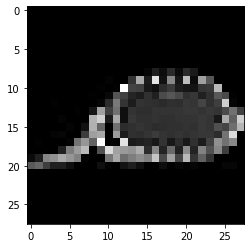

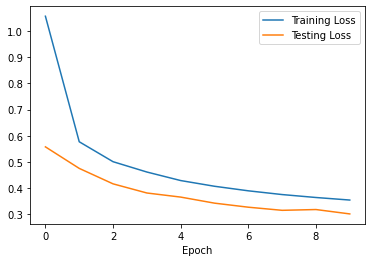

In [19]:
model=build_model(dropout_rate=0.50,nfilters=32,activation='sigmoid')
history=model.fit(X_train, Y_train_one_hot, 
      batch_size=32, epochs=10,
     validation_data=(X_develop,Y_develop_one_hot) )   
score = model.evaluate(X_develop, Y_develop_one_hot)
print("Develop loss: {}, Develop accuracy: {}".format(*score))

score = model.evaluate(X_train, Y_train_one_hot)
print("Train loss: {}, Train accuracy: {}".format(*score))
check(model,X_develop,Y_develop)
plot_history(history)

## Leaky ReLU

Epoch 1/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.4957 - accuracy: 0.8257 - val_loss: 0.3547 - val_accuracy: 0.8758
Epoch 2/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.3719 - accuracy: 0.8703 - val_loss: 0.3293 - val_accuracy: 0.8834
Epoch 3/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.3423 - accuracy: 0.8785 - val_loss: 0.3098 - val_accuracy: 0.8906
Epoch 4/10
1499/1499 [==============================] - 4s 2ms/step - loss: 0.3192 - accuracy: 0.8862 - val_loss: 0.3031 - val_accuracy: 0.8900
Epoch 5/10
1499/1499 [==============================] - 6s 4ms/step - loss: 0.3089 - accuracy: 0.8896 - val_loss: 0.2909 - val_accuracy: 0.8957
Epoch 6/10
1499/1499 [==============================] - 4s 3ms/step - loss: 0.2992 - accuracy: 0.8929 - val_loss: 0.2825 - val_accuracy: 0.9012
Epoch 7/10
1499/1499 [==============================] - 4s 3ms/step - loss: 0.2913 - accuracy: 0.8967 - val_loss: 0.3002 - val_accuracy:

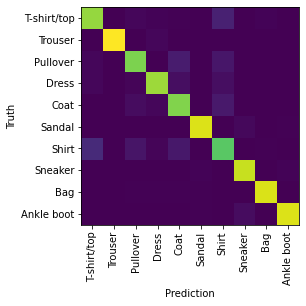

Number of Incorrect Guesses: 1138


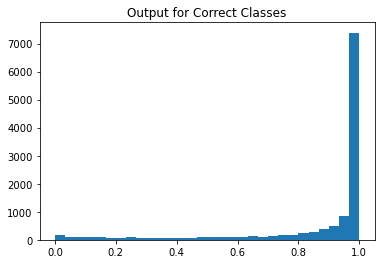

Guess: Coat /Truth: Bag


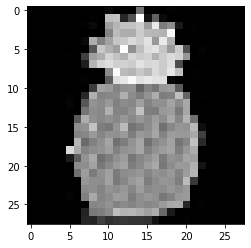

Guess: Sneaker /Truth: Bag


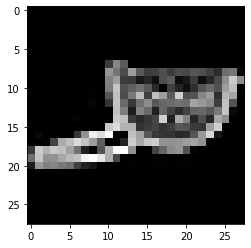

Guess: Sneaker /Truth: Bag


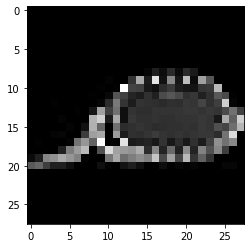

Guess: Bag /Truth: Sandal


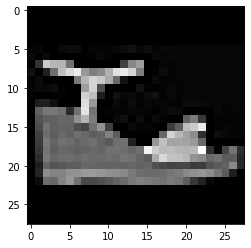

Guess: Coat /Truth: Bag


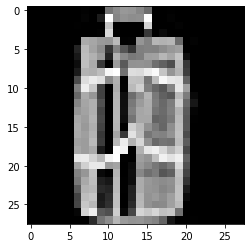

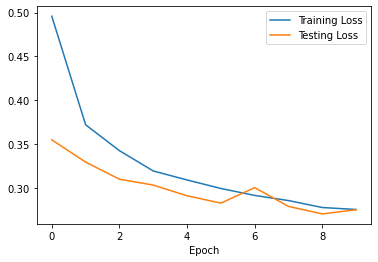

In [20]:
model=build_model(dropout_rate=0.50,nfilters=32,use_leakyRelu=True)
history=model.fit(X_train, Y_train_one_hot, 
      batch_size=32, epochs=10,
     validation_data=(X_test,Y_test_one_hot) )    
score = model.evaluate(X_test, Y_test_one_hot)
print("Test loss: {}, Test accuracy: {}".format(*score))

score = model.evaluate(X_train, Y_train_one_hot)
print("Train loss: {}, Train accuracy: {}".format(*score))
check(model,X_develop,Y_develop)
plot_history(history)

# Give it a Try on the cifar dataset
* Try some of the options above to get the best accuracy you can with cifar?


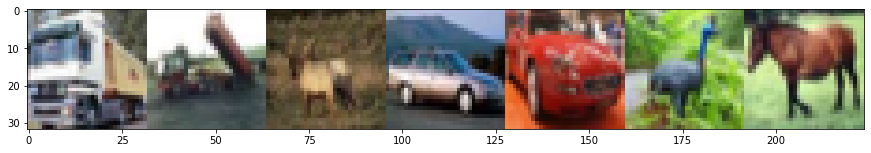

In [33]:
# Load CIFAR data into train and test sets
(_cfxtrain, _cfytrain), (cfX_test, cfY_test) = tf.keras.datasets.cifar10.load_data()
cfY_test=np.squeeze(cfY_test)
_cfytrain=np.squeeze(_cfytrain)

#Split into Train and Develop

train_index=[]
develop_index=[]
for i in range(len(_cfxtrain)):
    if random() <0.8:
        train_index.append(i)
    else:
        develop_index.append(i)
cfX_train=_cfxtrain[train_index]
cfY_train=_cfytrain[train_index]

cfX_develop=_cfxtrain[develop_index]
cfY_develop=_cfytrain[develop_index]

f=plt.figure(figsize=(15,3))
plt.imshow(np.hstack(cfX_train[0:7])) #hstack aranges the first 7 images into one long image

if np.max(cfX_train) >1:
    cfX_train=cfX_train/255
    cfX_develop=cfX_develop/255.
    cfX_test=cfX_test/255.
 
cfY_train_one_hot=tf.keras.utils.to_categorical(cfY_train, 10)
cfY_develop_one_hot=tf.keras.utils.to_categorical(cfY_develop, 10)
cfY_test_one_hot=tf.keras.utils.to_categorical(cfY_test, 10)

   
    

In [48]:
"Write and Train your model here"


input_layer=tf.keras.layers.Input( shape=cfX_train.shape[1:] ) # Shape here does not include the batch size 
#Add CNN Blocks here
cnn_layer1=tf.keras.layers.Convolution2D(256, (3,3),strides=1,padding='same')(input_layer) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer1) 
pool_out=tf.keras.layers.MaxPooling2D()(cnn_activation)
dropout=tf.keras.layers.Dropout(0.3)(pool_out)

cnn_layer2=tf.keras.layers.Convolution2D(512, (3,3),strides=1,padding='same')(dropout) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer2) 
pool_out=tf.keras.layers.MaxPooling2D()(cnn_activation)
dropout=tf.keras.layers.Dropout(0.3)(pool_out)

cnn_layer3=tf.keras.layers.Convolution2D(1024, (3,3),strides=1,padding='same')(dropout) 
cnn_activation=tf.keras.layers.LeakyReLU()(cnn_layer3) 
pool_out=tf.keras.layers.MaxPooling2D()(cnn_activation)
dropout=tf.keras.layers.Dropout(0.3)(pool_out)
flat_input=tf.keras.layers.Flatten()(dropout )#Dense layers take a shape of ( batch x features)
##
hidden_layer1=tf.keras.layers.Dense(512)(flat_input)    
hidden_layer_activation=tf.keras.layers.LeakyReLU()(hidden_layer1)
dropout=tf.keras.layers.Dropout(0.3)(hidden_layer_activation)

hidden_layer2=tf.keras.layers.Dense(256)(dropout)
hidden_layer_activation=tf.keras.layers.LeakyReLU()(hidden_layer2)
dropout=tf.keras.layers.Dropout(0.3)(hidden_layer_activation)

hidden_layer3=tf.keras.layers.Dense(128)(dropout)
hidden_layer_activation=tf.keras.layers.LeakyReLU()(hidden_layer3)
dropout=tf.keras.layers.Dropout(0.3)(hidden_layer_activation)


output_layer=tf.keras.layers.Dense(n_targets,activation='softmax')(dropout)

cifar_model=tf.keras.models.Model(input_layer,output_layer)

cifar_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

cifar_model.summary()



"your code here"
history=cifar_model.fit(cfX_train, cfY_train_one_hot, 
          batch_size=32, epochs=20, verbose=1,
         validation_data=(cfX_develop,cfY_develop_one_hot)
         )


Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 32, 32, 256)       7168      
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
dropout_39 (Dropout)         (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 16, 16, 512)       1180160   
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 16, 16, 512)       0  

making 10000 predictions for 10 classes


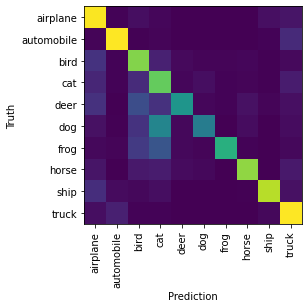

Number of Incorrect Guesses: 3250


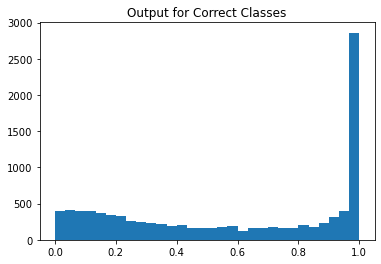

Guess: automobile /Truth: truck


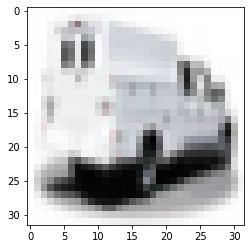

Guess: automobile /Truth: truck


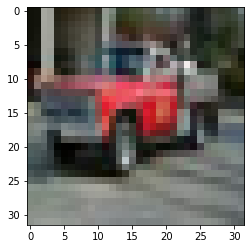

Guess: bird /Truth: truck


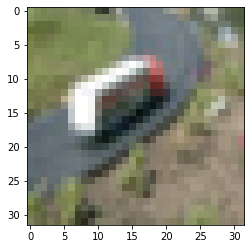

Guess: bird /Truth: ship


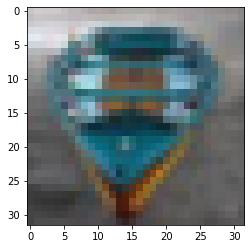

Guess: automobile /Truth: truck


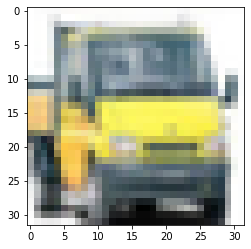

1.0


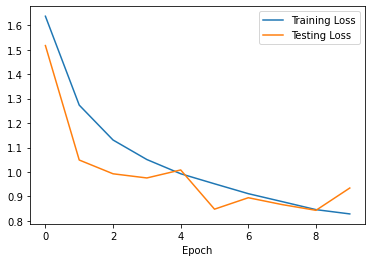

In [47]:
check(cifar_model,cfX_test,cfY_test,labels=['airplane',
                'automobile', 
                'bird',
                'cat', 
                'deer', 
                'dog',
                'frog', 
                'horse', 
                'ship', 
                'truck'])
print(np.max(cfX_develop))
plot_history(history)